In [165]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# use these lines at the end of data-preparation to get clipped_data.csv
data = data[data.session_id <= 20000]
data.drop(['hist_user_behavior_reason_end', 'skip_1', 'skip_2', 'skip_3', 'session_id'], axis=1, inplace=True)
data.to_csv('./data/clipped_data.csv')

In [197]:
raw_data = pd.read_csv('./data/clipped_data.csv')
y = raw_data['not_skipped']
raw_data.drop(['not_skipped', 'Unnamed: 0'], axis=1, inplace=True)
columns = raw_data.columns
raw_data = pd.DataFrame(StandardScaler().fit_transform(raw_data), columns=columns)
X_train, X_test, y_train, y_test = train_test_split(raw_data, y, test_size = 0.25, shuffle = True, random_state= 2001)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, shuffle = True, random_state= 2022)
X_train

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
12575,-1.429275,0.681944,-0.218647,-1.578338,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,0.968958,...,0.149062,-0.975873,-0.431383,0.514973,0.951803,0.003519,-0.617304,0.470500,-0.135089,0.057216
139988,0.413331,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,1.469694,...,0.149062,1.802820,-0.316789,0.972022,1.589783,0.923791,0.973468,0.487320,2.403868,0.134691
56216,1.518894,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,0.134397,...,0.149062,0.617122,0.873800,0.370938,-0.174786,-1.263426,0.901582,0.819490,-0.750319,-1.698549
120888,-1.429275,0.089332,-0.218647,-1.578338,-0.404558,-0.445681,2.618657,-0.115693,-0.653611,0.134397,...,0.149062,-0.771903,0.849128,-0.967778,-1.263611,-0.887162,1.163613,0.887784,-0.625656,-0.538548
97730,0.044810,-0.206974,-0.218647,-1.578338,2.471831,2.243759,-0.134574,-0.115693,-0.653611,-0.700163,...,0.149062,-1.079259,-0.735213,0.046869,-0.269483,0.485190,-0.528858,-0.629586,-0.607584,0.485332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30451,1.887415,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,0.968958,...,-2.874445,-0.956179,2.451101,-2.680631,-2.459658,-0.977732,0.308548,0.531793,0.257052,0.012089
152556,0.044810,-1.095892,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,-0.032515,...,0.149062,-0.470161,-0.909802,0.541354,0.691299,0.273945,-0.600785,0.054287,-0.531294,0.359749
5452,0.044810,-0.206974,-0.218647,-1.578338,2.471831,2.243759,-0.134574,-0.115693,1.529961,1.469694,...,0.149062,-1.838737,2.104809,-2.341289,-2.487015,0.333201,-0.475326,-1.218144,1.432851,1.064619
68106,0.044810,0.681944,-0.218647,0.633578,-0.404558,-0.445681,-0.134574,-0.115693,-0.653611,-0.700163,...,0.149062,0.988427,1.247781,-1.600237,0.380791,0.892728,0.488825,-1.458435,1.523461,-2.365966


In [198]:
y

0         0.0
1         0.0
2         1.0
3         0.0
4         0.0
         ... 
165671    1.0
165672    1.0
165673    0.0
165674    0.0
165675    0.0
Name: not_skipped, Length: 165676, dtype: float64

In [199]:
class SkipDataset(Dataset):

    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_idx_tmp = np.array(self.X.iloc[idx])
        y_idx_tmp = np.array(self.y.iloc[idx])

        return torch.Tensor(x_idx_tmp), torch.Tensor(y_idx_tmp) 
        



In [200]:
batch_size = 128

train_data = SkipDataset(X_train, y_train)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle = True)

test_data = SkipDataset(X_test, y_test)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle = True)

val_data = SkipDataset(X_val, y_val)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle = True)

In [206]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(FeedForward, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size,output_size)
        )

    def forward(self,x):
        return self.model(x)

        

In [207]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [236]:
net = FeedForward(42, 1, 32)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.00001)
epochs = 300

In [ ]:
costs = []

In [240]:
epochs = 1000

In [241]:
print_statement = "Epoch: {} \t Loss: {:.4f} \t Avg. Validation Batch Accuracy: {:.4f} "

for epoch in range(300, epochs):
    epoch_loss = 0

    for i, (x_inst, y_inst) in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        y_pred = net.forward(x_inst)
        cost = criterion(y_pred, y_inst.reshape(-1, 1))

        cost.backward()
        optimizer.step()

        epoch_loss += cost.abs().item()

    costs.append(epoch_loss)

    if epoch % 5 == 0:
        n_batches = 0
        running_acc = 0
        for i, (x_val_inst, y_val_inst) in enumerate(val_dataloader):
            n_batches += 1
            y_val_pred = net.forward(x_val_inst).sigmoid().round()
            running_acc += accuracy_score(y_val_inst.detach().numpy(), y_val_pred.detach().numpy())

            
        print(print_statement.format(epoch, epoch_loss, running_acc / n_batches))

        torch.save(net.state_dict(), f"./saved_models/feed_forward_{epoch}.pt")

        

Epoch: 300 	 Loss: 441.2876 	 Avg. Validation Batch Accuracy: 0.6724 
Epoch: 305 	 Loss: 440.9867 	 Avg. Validation Batch Accuracy: 0.6718 
Epoch: 310 	 Loss: 440.6675 	 Avg. Validation Batch Accuracy: 0.6721 
Epoch: 315 	 Loss: 440.3692 	 Avg. Validation Batch Accuracy: 0.6719 
Epoch: 320 	 Loss: 440.0839 	 Avg. Validation Batch Accuracy: 0.6722 
Epoch: 325 	 Loss: 439.7990 	 Avg. Validation Batch Accuracy: 0.6723 
Epoch: 330 	 Loss: 439.4886 	 Avg. Validation Batch Accuracy: 0.6721 
Epoch: 335 	 Loss: 439.2468 	 Avg. Validation Batch Accuracy: 0.6722 
Epoch: 340 	 Loss: 438.9582 	 Avg. Validation Batch Accuracy: 0.6722 
Epoch: 345 	 Loss: 438.7178 	 Avg. Validation Batch Accuracy: 0.6717 
Epoch: 350 	 Loss: 438.4712 	 Avg. Validation Batch Accuracy: 0.6718 
Epoch: 355 	 Loss: 438.2049 	 Avg. Validation Batch Accuracy: 0.6719 
Epoch: 360 	 Loss: 437.9693 	 Avg. Validation Batch Accuracy: 0.6725 
Epoch: 365 	 Loss: 437.7345 	 Avg. Validation Batch Accuracy: 0.6720 
Epoch: 370 	 Loss: 4

KeyboardInterrupt: 

In [238]:
correct = 0
for x_inst, y_inst in test_data:
    y_pred = net.forward(x_inst)
    correct += (1 - (y_pred.sigmoid().round() - y_inst).abs()).abs()

acc = (correct / len(test_data)).item()
print(f"Epoch: {i} \t Accuracy: {acc}")

Epoch: 679 	 Accuracy: 0.6714068651199341


In [222]:
accs = []
for i in range(0, 265, 5):
    net.load_state_dict(torch.load(f'./saved_models/feed_forward_{i}.pt'))
    correct = 0
    for x_inst, y_inst in test_data:
        y_pred = net.forward(x_inst)
        correct += (1 - (y_pred.sigmoid().round() - y_inst).abs()).abs()

    acc = (correct / len(test_data)).item()
    print(f"Epoch: {i} \t Accuracy: {acc}")
    accs.append(acc)


KeyboardInterrupt: 

-0.2733489154115508


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

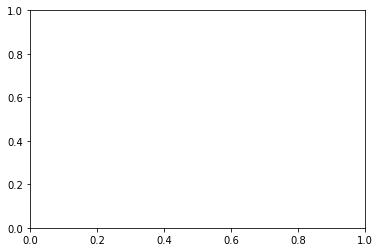

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
      

0.5078125

array([ 1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       -1,  1,  1, -1,  1, -1, -1,  1])